In [ ]:
# for loading/processing the images  
import tensorflow as tf

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.resnet_v2 import preprocess_input 

# models 
from tensorflow.keras.applications import VGG16,VGG19,ResNet101V2
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score,homogeneity_score,silhouette_score,roc_curve,roc_auc_score


# Defining the model 



*   Je vais  utiliser un dataset aribtraire, exemple : Flower dataset dans Kaggle après on change ça avec notre propore dataset 

*   Ajout de pooling pour réduire la dimension 
*   Utilisation d'un VGG au lieu d'un Resnet 
*   Réduire les dimesnions avec un PCA 
*   application de Kmeans pour culstering










In [ ]:
model = ResNet101V2(include_top=True,weights='imagenet',input_shape=(224,224,3),pooling='max')

179527680/179518384 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [ ]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
from numpy.ma.mrecords import fromrecords
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!ls

drive  Query_2.csv  sample_data


In [ ]:
base_dir = "/content/drive/My Drive/PMA"

In [ ]:
samples = []

list_of_files = sorted( filter( lambda x: os.path.isfile(os.path.join(base_dir, x)),
                        os.listdir(base_dir) ) )
for file in list_of_files : 
  if file.endswith('.jpg') or file.endswith('.png'):
    samples.append(file)

In [ ]:
samples[:5]

['0008255f72057dbf97e229199e6595e2deebecfd.jpg',
 '000ae4b433acb21229b17679d28f9a148fad3429.jpg',
 '001dee6bb8c2280e1182e11d5fb87f5a5272753b.jpg',
 '0023593bc7d99ef1dded8b21ab9e61214e86cfd6.jpg',
 '003006be00fa0b45687c9413ba52fea04b7dac9b.jpg']

# Data Preprocessing

In [ ]:
csv = [os.path.splitext(each)[0] for each in samples]
len(csv)

3095

In [ ]:
df_img = pd.DataFrame (csv, columns = ['file'])
df_img

,file
0,0008255f72057dbf97e229199e6595e2deebecfd
1,000ae4b433acb21229b17679d28f9a148fad3429
2,001dee6bb8c2280e1182e11d5fb87f5a5272753b
3,0023593bc7d99ef1dded8b21ab9e61214e86cfd6
4,003006be00fa0b45687c9413ba52fea04b7dac9b
...,...
3090,ff443c2ee2c8e9cd5d69fa4d1ba586976d6987dd
3091,ff75548e5c9191e2bf2973b99ce30b10d95d7ae0
3092,ff92d1ffb9cb58c1db997b5ed9b13a7fa6a22f1d
3093,ffa77976eb38c938e8a643ef2249333af0b1cf41


In [ ]:
df_labels = pd.read_csv('Query_2.csv',on_bad_lines='skip',sep=';')
df_labels


,file,tag_label
0,1219581b450f4327e8badb38c239d384ef560462,Manifestation
1,88d0b08b9d8101e4a143ae54d41ac0f62c5a8beb,Famille
2,59a05fdf34c43d6ab7007af107278e0f67f7e870,Amendements loi bioethique
3,dac5743d1056bce579a13c4504b4c30a9b85d308,Twitter
4,c55ddf20703dc8f59a94947fc9f149c2804228bf,Vidéos
...,...,...
9801,d9371fd02a950f43dda962458b0fa37b42e2b75e,Manifestation
9802,f63db86de857ea828171da52f1eb8a2a5fa63712,Manifestation
9803,0ab50bb88d9262f04835d1b467acf7e074b8fb4d,Jean-Louis Tourraine
9804,74945cc833870f42152b99d5025fed027e672198,Hors Corpus


In [ ]:
df3 = pd.merge(df_img,df_labels,how='inner')
df3

,file,tag_label
0,0008255f72057dbf97e229199e6595e2deebecfd,Ludovine de la Rochère
1,0008255f72057dbf97e229199e6595e2deebecfd,Personnalité Politique
2,0008255f72057dbf97e229199e6595e2deebecfd,Médias / journalistes
3,0008255f72057dbf97e229199e6595e2deebecfd,Manifestation
4,000ae4b433acb21229b17679d28f9a148fad3429,Manifestation
...,...,...
7607,ff92d1ffb9cb58c1db997b5ed9b13a7fa6a22f1d,Femme enceinte / Ventre
7608,ff92d1ffb9cb58c1db997b5ed9b13a7fa6a22f1d,Famille
7609,ffa77976eb38c938e8a643ef2249333af0b1cf41,Echarpe tricolore
7610,ffa77976eb38c938e8a643ef2249333af0b1cf41,Manifestation


In [ ]:
df3 = df3.drop_duplicates(subset = ["file"])
df3

,file,tag_label
0,0008255f72057dbf97e229199e6595e2deebecfd,Ludovine de la Rochère
4,000ae4b433acb21229b17679d28f9a148fad3429,Manifestation
7,001dee6bb8c2280e1182e11d5fb87f5a5272753b,Personnalité Politique
9,0023593bc7d99ef1dded8b21ab9e61214e86cfd6,Personnes
11,003006be00fa0b45687c9413ba52fea04b7dac9b,Personnes
...,...,...
7598,ff443c2ee2c8e9cd5d69fa4d1ba586976d6987dd,Foule
7604,ff75548e5c9191e2bf2973b99ce30b10d95d7ae0,Manifestation
7607,ff92d1ffb9cb58c1db997b5ed9b13a7fa6a22f1d,Femme enceinte / Ventre
7609,ffa77976eb38c938e8a643ef2249333af0b1cf41,Echarpe tricolore


In [ ]:
df_set = df3.groupby(['tag_label'])
df_set.count()

,file
tag_label,
Facebook,2
#MarchonsEnfants,6
#TousParents,2
?,10
Affiches déchirées,6
...,...
Twitter,33
Vie domestique,1
Vincent Thiébaut,2


In [ ]:
data_classes = set(df3['tag_label'].tolist())
data_classes = list(data_classes)
len(data_classes)

125

In [ ]:
y = df3['tag_label'].apply(data_classes.index)
len(y)


3054

In [ ]:
import os
os.chdir(base_dir)

img = load_img(samples[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)


(224, 224, 3)


In [ ]:
# reshaping the images 
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)

(1, 224, 224, 3)


In [ ]:

def get_features(file, model):
    # get l'image  224x224 
    img = load_img(file, target_size=(224,224))
    # convertir l'image en numpy
    img = np.array(img) 
    # batch_size = 1, taille = 224x224 , channel = 3
    reshaped_img = img.reshape(1,224,224,3) 
    # passage vers le modele
    imgx = preprocess_input(reshaped_img)
    # get le vecteur de feature
    features = model.predict(imgx, use_multiprocessing=True)
    return features


In [ ]:
from warnings import catch_warnings
# boucle sur l'ensemble des images

data = {}

for img in df_labels['file'].tolist():
  try : 
      img = samples[csv.index(img)]  
      feat = get_features(img,model)
      data[img] = feat
  except : 
    print(img)

filenames = np.array(list(data.keys()))

# liste des features
feat = np.array(list(data.values()))
feat.shape



76fa5a0a4a23f8fa52c7ffb6312c9379ab4ccff5
46bbd64bdce297c1374b8ff7385186a5d7a4ebbc
ea12cf9a41b0182f3b8fd8a0f6d94eb4a2ef0ed8


In [ ]:
feat = feat.reshape(-1,2048)
feat.shape


In [ ]:
np.save('feature_pma',feat)

In [ ]:
feat = np.load('feature_pma.npy')
feat.shape

(3054, 2048)

# PCA

In [ ]:
#application de PCA
pca = PCA(n_components=150, random_state=42)
pca.fit(feat)
x = feat

# Kmeans 




In [ ]:
kmeans = KMeans(n_clusters=125,init='k-means++')
kmeans.fit(x)

KMeans(n_clusters=125)

In [ ]:
kmeans.labels_


array([ 48, 122,  61, ...,  86,  26,   0], dtype=int32)

In [ ]:


def cluster_groups(kmeans): 
  groups = {}
  for file, cluster in zip(filenames,kmeans.labels_):
      if cluster not in groups.keys():
          groups[cluster] = []
          groups[cluster].append(file)
      else:
          groups[cluster].append(file)
  return groups 
  

In [ ]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    files = groups[cluster]
    
    # Afficher chaque image dans son cluster 
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

# Defining metrics 

In [ ]:
label = y[:3054].to_numpy()


In [ ]:
def classifier_summary(y_test, y_pred_test):

    
    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),4)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),4)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),4)
    test_kappa =  np.round(cohen_kappa_score(y_test, y_pred_test),4) 
    homogeneity = np.round(homogeneity_score(y_test, y_pred_test),4)
    test_confusion_matrix = confusion_matrix(y_test,y_pred_test)
    

    
    

    
    print()
    print('------------------------ Test Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Cohen Kappa Score : {} ".format(test_kappa))
    print("Recall : {}".format(test_recall))
    print("Precision : {}".format(test_precision))
    print("Humogeneity : {}".format(homogeneity))
    print("Confusion Matrix : {}".format(test_confusion_matrix))

    print("-"*80)
    print()

    return homogeneity

In [ ]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    # Loop through the clusters
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  

In [ ]:
def infer_data_labels(Y_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(Y_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(Y_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [ ]:
clusters = [150]
iner_list = []
homo_list = []
acc_list = []

for n_clusters in clusters:
    pca = PCA(n_components=n_clusters, random_state=42)
    pca.fit(feat)
    x = feat
    kmeans = KMeans(n_clusters=125)
    kmeans.fit(x)
    
   
    iner_list.append(kmeans.inertia_)
    
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(kmeans, label)
    prediction = infer_data_labels(kmeans.labels_, cluster_labels)
    homo = classifier_summary(label, prediction)
    homo_list.append(homo)

    acc = accuracy_score(label, prediction)
    acc_list.append(acc)


------------------------ Test Set Metrics------------------------

accuracy : 20.66%
F1_score : 0.1082
Cohen Kappa Score : 0.047 
Recall : 0.2066
Precision : 0.1766
Humogeneity : 0.0406
Confusion Matrix : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
--------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

In [ ]:
from keras.utils.np_utils import to_categorical   

categorical_labels = one_hot(label, 125).astype(int)

categorical_prediction = one_hot(prediction,125).astype(int)


fpr, tpr, _ = roc_curve(categorical_labels,categorical_prediction)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ValueError: ignored

In [ ]:
categorical_prediction.squeeze().shape

(381750, 125)

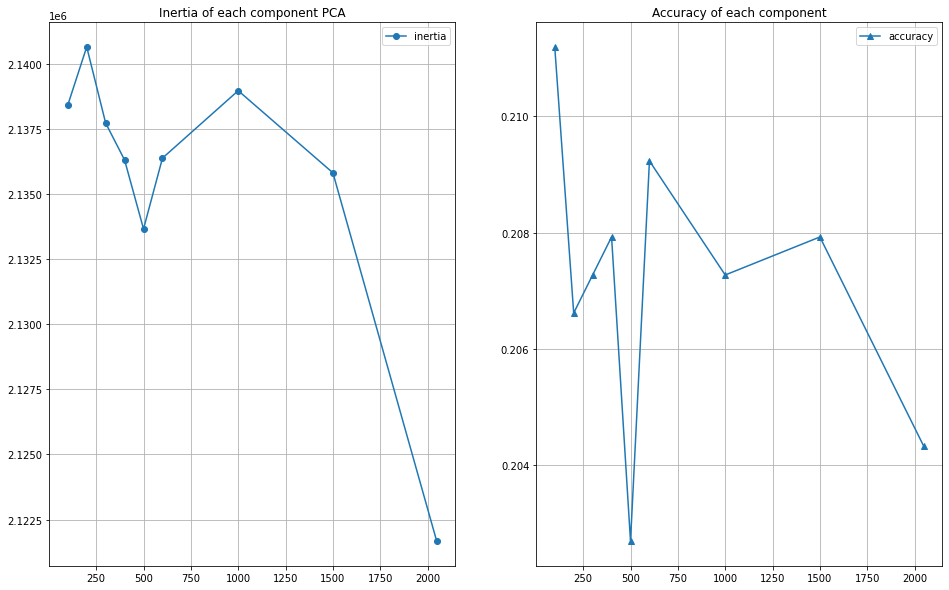

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].plot(clusters, iner_list, label='inertia', marker='o')
ax[1].plot(clusters, acc_list, label='accuracy', marker='^')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].grid('on')
ax[1].grid('on')
ax[0].set_title('Inertia of each component PCA')
ax[1].set_title('Accuracy of each component')
plt.show()

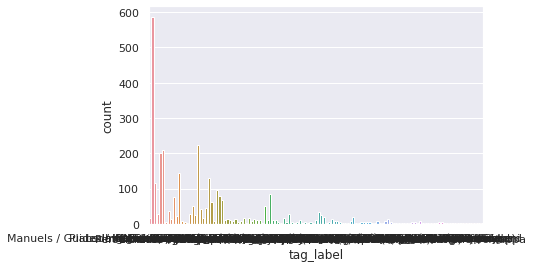

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="tag_label", data=df3)

In [ ]:
df3['tag_label'].value_counts()

Manifestation      587
Autre              224
Foule              209
Hors Corpus        201
Texte              145
                  ... 
Maxime Minot         1
Jean Lasalle         1
Extrêmistes          1
Emmanuel Macron      1
Gilbert Collard      1
Name: tag_label, Length: 125, dtype: int64

In [ ]:

count_one = df3['tag_label'].value_counts().tolist()
count_class = []
for i in sorted(list(set(count_one))) : 
  count_class.append(count_one.count(i))


In [ ]:
sorted(list(set(count_one)))


[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 22,
 25,
 27,
 28,
 29,
 33,
 36,
 41,
 45,
 50,
 51,
 63,
 67,
 75,
 79,
 85,
 97,
 117,
 131,
 145,
 201,
 209,
 224,
 587]

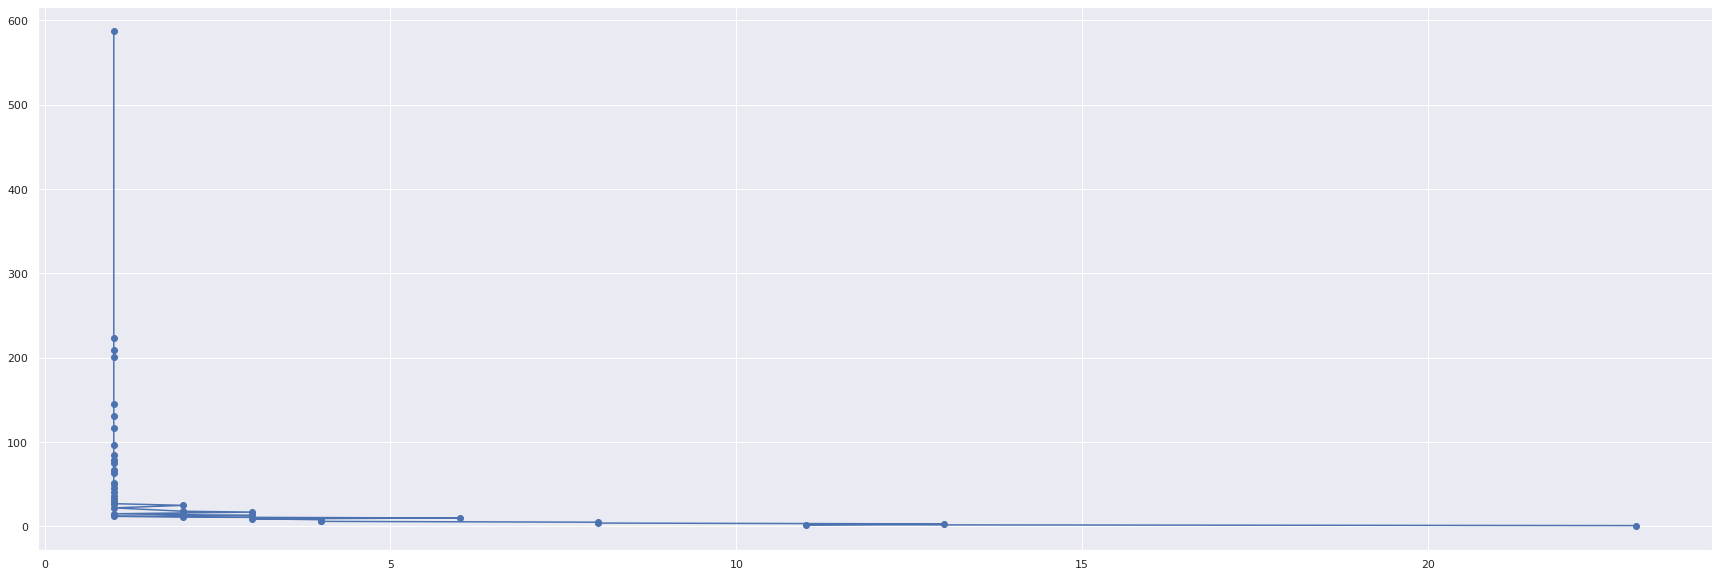

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
ax.plot(count_class, sorted(list(set(count_one))) , label='Count class', marker='o')

plt.show()

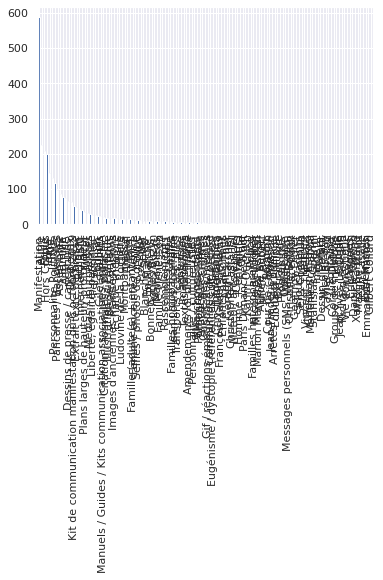

In [ ]:
df3['tag_label'].value_counts().plot.bar()


In [ ]:
!unzip "/content/drive/My Drive/dataset.zip" -d '/content/dataset_pma'

Archive:  /content/drive/My Drive/dataset.zip
replace /content/dataset_pma/dataset/test/000ae4b433acb21229b17679d28f9a148fad3429.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset_pma/dataset/test/001dee6bb8c2280e1182e11d5fb87f5a5272753b.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/dataset_pma/dataset/test/001dee6bb8c2280e1182e11d5fb87f5a5272753b.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/dataset_pma/dataset/test/001dee6bb8c2280e1182e11d5fb87f5a5272753b.jpg  
  inflating: /content/dataset_pma/dataset/test/003006be00fa0b45687c9413ba52fea04b7dac9b.jpg  
  inflating: /content/dataset_pma/dataset/test/003e061aff45fa8a16b37de25a9061f11cbfe2b4.jpg  
  inflating: /content/dataset_pma/dataset/test/004fcd36004f928e566d58426b27a4bee1892e15.jpg  
  inflating: /content/dataset_pma/dataset/test/005cdab3d404a3db48e744786af572a4752b54b9.jpg  
  inflating: /content/dataset_pma/dataset/test/007fd1eac4d8e69d181908d5

In [ ]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
base_dir = '/content/dataset_pma/dataset'
train_dir = '/content/dataset_pma/dataset/train/'
val_dir = '/content/dataset_pma/dataset/val/'
test_dir = '/content/dataset_pma/dataset/test/'

In [ ]:
IMG_SHAPE = 224 
batch_size = 32

In [ ]:
import os
os.chdir(base_dir)

In [ ]:
df3

,file,tag_label
0,0008255f72057dbf97e229199e6595e2deebecfd,Ludovine de la Rochère
4,000ae4b433acb21229b17679d28f9a148fad3429,Manifestation
7,001dee6bb8c2280e1182e11d5fb87f5a5272753b,Personnalité Politique
9,0023593bc7d99ef1dded8b21ab9e61214e86cfd6,Personnes
11,003006be00fa0b45687c9413ba52fea04b7dac9b,Personnes
...,...,...
7598,ff443c2ee2c8e9cd5d69fa4d1ba586976d6987dd,Foule
7604,ff75548e5c9191e2bf2973b99ce30b10d95d7ae0,Manifestation
7607,ff92d1ffb9cb58c1db997b5ed9b13a7fa6a22f1d,Femme enceinte / Ventre
7609,ffa77976eb38c938e8a643ef2249333af0b1cf41,Echarpe tricolore


In [ ]:
final_list = sorted(list(set(df3['file'].tolist()).intersection(set(df_img['file'].tolist()))))

In [ ]:
final_list_jpg = [i+'.jpg' for i in final_list]
final_list_png = [i+'.png' for i in final_list]

In [ ]:
list_train = list(set(os.listdir(train_dir)).intersection(set(final_list_jpg))) + list(set(os.listdir(train_dir)).intersection(set(final_list_png)))
list_val = list(set(os.listdir(val_dir)).intersection(set(final_list_jpg)))+ list(set(os.listdir(val_dir)).intersection(set(final_list_png)))
list_test = list(set(os.listdir(test_dir)).intersection(set(final_list_jpg))) + list(set(os.listdir(test_dir)).intersection(set(final_list_png)))

In [ ]:
x_train=[]

for f in list_train:
  
  
  img = cv2.imread(train_dir+f)
    # convertir l'image en numpy
  img = cv2.resize(img,(224,224))

  x_train.append(img)

x_test=[]

for f in list_test:
  img = cv2.imread(test_dir+f)
    # convertir l'image en numpy
  img = cv2.resize(img,(224,224))

  x_test.append(img)



In [ ]:
x_val=[]

for f in list_val:
  img = cv2.imread(val_dir+f)
    # convertir l'image en numpy
  try:
    img = cv2.resize(img,(224,224))
  except : 
    print(img)

  x_val.append(img)

In [ ]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [ ]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
d = {'file':final_list, 'y' : y.tolist()}

df_final = pd.DataFrame(d)
df_final

,file,y
0,0008255f72057dbf97e229199e6595e2deebecfd,101
1,000ae4b433acb21229b17679d28f9a148fad3429,65
2,001dee6bb8c2280e1182e11d5fb87f5a5272753b,18
3,0023593bc7d99ef1dded8b21ab9e61214e86cfd6,115
4,003006be00fa0b45687c9413ba52fea04b7dac9b,115
...,...,...
3049,ff443c2ee2c8e9cd5d69fa4d1ba586976d6987dd,111
3050,ff75548e5c9191e2bf2973b99ce30b10d95d7ae0,65
3051,ff92d1ffb9cb58c1db997b5ed9b13a7fa6a22f1d,10
3052,ffa77976eb38c938e8a643ef2249333af0b1cf41,121


In [ ]:
from pandas.core.dtypes.common import classes
training_set = train_datagen.flow_from_directory(base_dir,
                                                 classes = ['train'],
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(base_dir,
                                            target_size = (224, 224),
                                            classes = ['test'],
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(base_dir,
                                            target_size = (224, 224),
                                            classes = ['val'],
                                            batch_size = 32,
                                            class_mode = 'sparse')


Found 619 images belonging to 1 classes.
Found 1548 images belonging to 1 classes.
Found 928 images belonging to 1 classes.


In [ ]:
list_train_csv = [os.path.splitext(each)[0] for each in list_train]
list_val_csv = [os.path.splitext(each)[0] for each in list_val]
list_test_csv = [os.path.splitext(each)[0] for each in list_test]


In [ ]:
train_y = pd.merge(pd.DataFrame(list_train_csv,columns=['file']),df_final,how = 'inner')['y'].to_numpy()
val_y = pd.merge(pd.DataFrame(list_val_csv,columns=['file']),df_final,how = 'inner')['y'].to_numpy()
test_y = pd.merge(pd.DataFrame(list_test_csv,columns=['file']),df_final,how = 'inner')['y'].to_numpy()



In [ ]:
pre_trained_model = tf.keras.applications.ResNet101V2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")


In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('conv5_block3_out')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(125, activation='softmax')(x)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])


In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

In [ ]:
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=100,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/100
20/20 [==============================] - 16s 801ms/step - loss: 0.1379 - acc: 0.9755 - val_loss: 6.4702 - val_acc: 0.2390
Epoch 2/100
20/20 [==============================] - 16s 799ms/step - loss: 0.1151 - acc: 0.9739 - val_loss: 6.1418 - val_acc: 0.2456
Epoch 3/100
20/20 [==============================] - 16s 804ms/step - loss: 0.0816 - acc: 0.9869 - val_loss: 6.0943 - val_acc: 0.2325
Epoch 4/100
20/20 [==============================] - 16s 805ms/step - loss: 0.1179 - acc: 0.9755 - val_loss: 6.8999 - val_acc: 0.2807
Epoch 5/100
20/20 [==============================] - 16s 805ms/step - loss: 0.1196 - acc: 0.9788 - val_loss: 6.5768 - val_acc: 0.2204
Epoch 6/100
20/20 [==============================] - 16s 805ms/step - loss: 0.2322 - acc: 0.9706 - val_loss: 7.3342 - val_acc: 0.2719
Epoch 7/100
20/20 [==============================] - 16s 804ms/step - loss: 0.1481 - acc: 0.9772 - val_loss: 7.0008 - val_acc: 0.2555
Epoch 8/100
20/20 [==============================] - 16s 804ms

In [ ]:
plt.plot(history.history['acc'], label='train acc')

plt.plot(history.history['val_acc'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-rps-1.png')

plt.show()